In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_00 import *

In [3]:
train_dl, valid_dl = get_dls(*get_ds(train_glob,valid_glob), bs = 8)
data = DataBunch(train_dl,valid_dl)
loss_func = nn.MSELoss()

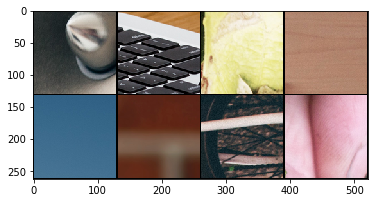

In [4]:
data.train_dl.show_batch()

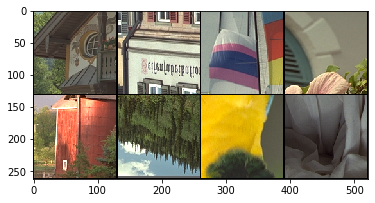

In [5]:
data.valid_dl.show_batch()

In [6]:
#export
import torch.nn.functional as F

In [7]:
#export
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [8]:
#export
def noop(x): return x

relu = nn.ReLU()

def conv(ni, nf, ks=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=ks,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    nn.init.zeros_(_conv.bias)
    return _conv

In [9]:
#export
def get_stats(w):
    return w.mean(), w.std()

Test if Zero Init like Fixup Works

In [10]:
#export
class ResBlock(nn.Module):
    def __init__(self, ni, nh=128):
        super().__init__()
        
        self.conv1 = conv(ni, nh)
        self.conv2 = conv(nh, ni)
        #initilize 2nd conv with zeros to preserve variance
        nn.init.zeros_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

    def forward(self, x):
        return x  + self.conv2(F.relu(self.conv1(x)))

In [11]:
tresblock = ResBlock(3)
get_stats(tresblock.conv1.weight)

(tensor(-0.0108, grad_fn=<MeanBackward0>),
 tensor(0.2650, grad_fn=<StdBackward0>))

In [12]:
test_eq(get_stats(tresblock.conv2.weight),(0.,0.))

In [13]:
tin = torch.randn(1,3,128,128)
tout = tresblock(tin)
test_eq(tout.shape,tin.shape)

In [14]:
# check identity mapping at the start of trainingin residual block
test_eq(get_stats(tin),get_stats(tout))

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers= [conv(3, 128, 8, 4, 2), relu,
                     ResBlock(128), relu,
                     conv(128, 256, 4, 2, 1), relu,
                     ResBlock(256), relu,
                     ResBlock(256),
                     conv(256, 64, 3, 1, 1),
                     nn.Sigmoid()]
        
        self.stem = nn.Sequential(*layers)
        nn.init.xavier_normal_(self.stem[9].weight)
        
    def forward(self,x):
        return self.stem(x)

````python
enc = Encoder().cuda()
from torchsummary import summary
summary(enc, (3,128,128))
````

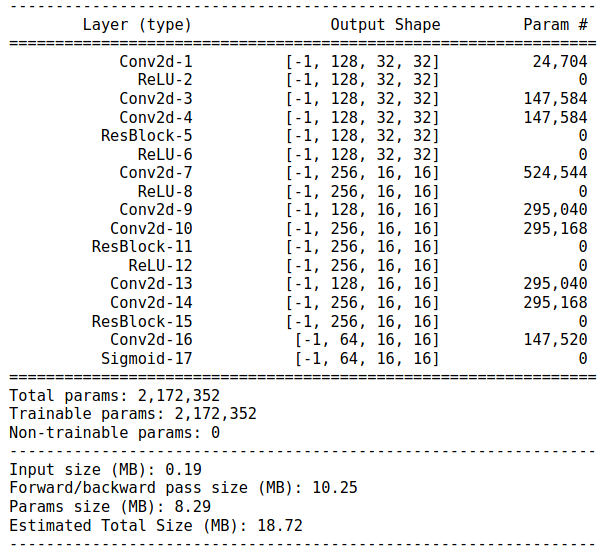

In [16]:
enc = Encoder()
enc

Encoder(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)

In [17]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [18]:
#export
class Binarizer(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, i):
        if i.is_cuda: return torch.where(i > 0.5, tensor(1.).cuda(), tensor(0.).cuda())
        return torch.where(i > 0.5, tensor(1.), tensor(0.))

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def bin_values(x):
    return Binarizer.apply(x)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [19]:
#export
class Binarizer(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, i):
        return (i>0.5).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def bin_values(x):
    return Binarizer.apply(x)

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [20]:
a = tensor([.34, .12, .67, .89, .01, 0.5])

In [21]:
(a>0.5).float()

tensor([0., 0., 1., 1., 0., 0.])

In [22]:
torch.where(a > 0.5, tensor(1.), tensor(0.))

tensor([0., 0., 1., 1., 0., 0.])

In [23]:
a

tensor([0.3400, 0.1200, 0.6700, 0.8900, 0.0100, 0.5000])

In [24]:
a = torch.rand(4,4,requires_grad=True)
print(a)

tensor([[0.9971, 0.5901, 0.7258, 0.2893],
        [0.7746, 0.5201, 0.4018, 0.5942],
        [0.4690, 0.7007, 0.2746, 0.7323],
        [0.8631, 0.5547, 0.6317, 0.6425]], requires_grad=True)


In [25]:
a.is_cuda

False

In [26]:
b = bin_values(a)
print(a)
print(b)

tensor([[0.9971, 0.5901, 0.7258, 0.2893],
        [0.7746, 0.5201, 0.4018, 0.5942],
        [0.4690, 0.7007, 0.2746, 0.7323],
        [0.8631, 0.5547, 0.6317, 0.6425]], requires_grad=True)
tensor([[1., 1., 1., 0.],
        [1., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.]], grad_fn=<BinarizerBackward>)


In [27]:
loss = b.sum()
print('Loss:{}'.format(loss))

Loss:12.0


In [28]:
loss.backward()
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [29]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers= [conv(3, 128, 8, 4, 2), relu,
                     ResBlock(128), relu,
                     conv(128, 256, 4, 2, 1), relu,
                     ResBlock(256), relu,
                     ResBlock(256),
                     conv(256, 64, 3, 1, 1),
                     nn.Sigmoid(),
                     Lambda(bin_values)]
        
        
        
        self.stem = nn.Sequential(*layers)
        nn.init.xavier_normal_(self.stem[9].weight)
    
    def extra_repr(self):
        return f'Made by Aditya'
    
    def forward(self,x):
        return self.stem(x)

In [30]:
enc = Encoder();enc

Encoder(
  Made by Aditya
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
    (11): Lambda()
  )
)

````python
enc = Encoder().cuda()
from torchsummary import summary
summary(enc, (3,128,128))
````

In [31]:
num_params = sum(p.numel() for p in enc.parameters())
num_params_train = sum(p.numel() for p in enc.parameters() if p.requires_grad)

In [32]:
num_params, num_params_train

(2172352, 2172352)

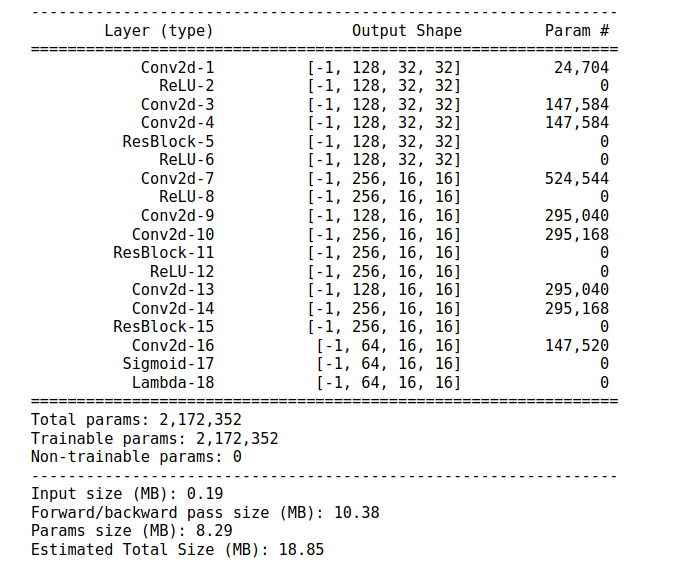

In [33]:
#export
class Encoder(nn.Module):
    def __init__(self,return_imp_map=False):
        super(Encoder, self).__init__()
        self.return_imp_map = return_imp_map
        self.stem = nn.Sequential(conv(3, 128, 8, 4, 2), relu,
                                   ResBlock(128), relu,
                                   conv(128, 256, 4, 2, 1), relu,
                                   ResBlock(256), relu,
                                   ResBlock(256), relu)

        self.head = nn.Sequential(conv(256, 64, 3, 1, 1), 
                                   nn.Sigmoid(),
                                   Lambda(bin_values))
         
        
        self.imp_map_extractor = nn.Sequential(conv(256,128), relu,
                                                conv(128,128), relu,
                                                conv(128,1), nn.Sigmoid())
        
        #initiating layers before Sigmoid with Xavier
        nn.init.xavier_normal_(self.head[0].weight)
        nn.init.xavier_normal_(self.imp_map_extractor[4].weight)
        
    def extra_repr(self):
        params = sum(p.numel() for p in self.parameters())
        return f'Total Params: {params}'
    
    def forward(self,x):
        stem = self.stem(x)
        if self.return_imp_map:return self.head(stem), self.imp_map_extractor(stem)
        else: return self.head(stem)

````python
enc = Encoder().cuda()
from torchsummary import summary
summary(enc, (3,128,128))
````

In [34]:
enc = Encoder();enc

Encoder(
  Total Params: 2616129
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): ReLU()
  )
  (head): Sequential(
    (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Lambda()
 

In [35]:
enc.modules

<bound method Module.modules of Encoder(
  Total Params: 2616129
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): ReLU()
    (8): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): ReLU()
  )
  (head): Sequential(
    (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

In [36]:
num_params = sum(p.numel() for p in enc.parameters())
num_params_train = sum(p.numel() for p in enc.parameters() if p.requires_grad)

In [37]:
num_params, num_params_train

(2616129, 2616129)

```python
enc = Encoder(return_imp_map=True).cuda()
from torchsummary import summary
summary(enc, (3,128,128))
````

In [38]:
2172352 + (128*256*3*3 + 128) +(128*128*3*3 + 128) +(1*3*3*128 +1)

2616129

In [39]:
!python notebook2script.py 01_encoder.ipynb

Converted 01_encoder.ipynb to exp/nb_01.py
